In [1]:
# %pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import *
import pandas as pd
import os
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost
import lightgbm

## Importar dados

In [3]:
treino = pd.read_csv('train.csv')

In [4]:
treino.set_index('id')

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19


In [5]:
treino.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


## Análise exploratória

In [6]:
treino.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [7]:
treino.isnull().values.any()

np.False_

<Axes: xlabel='accident_risk', ylabel='Count'>

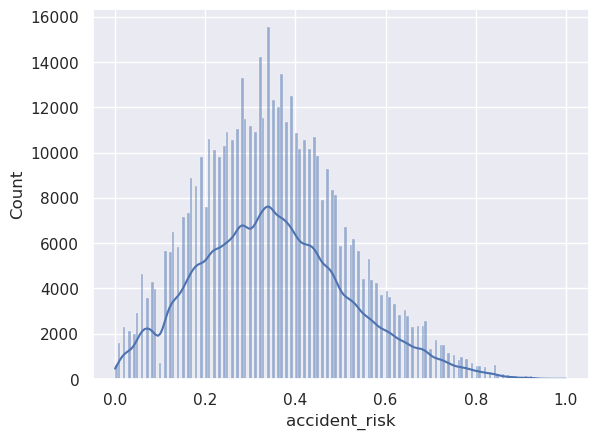

In [8]:
# usar tema padrão do sns
sns.set_theme()

sns.histplot(treino['accident_risk'], kde=True)

<Axes: >

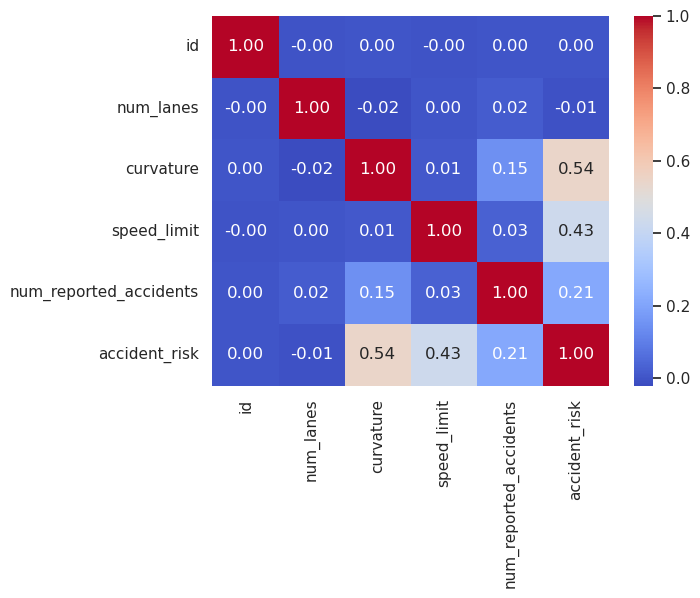

In [9]:
# pegar apenas colunas numéricas para criar heatmap
treino_corr = treino.select_dtypes(include=np.number)

sns.heatmap(treino_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")

Text(0.5, 1.0, 'Distribuição Curvatura')

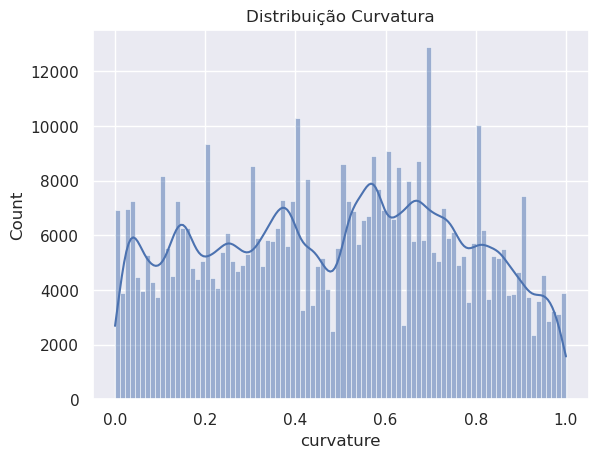

In [10]:
sns.histplot(treino['curvature'], kde=True)
plt.title('Distribuição Curvatura')

Text(0.5, 1.0, 'Distribuição Limite de Velocidade')

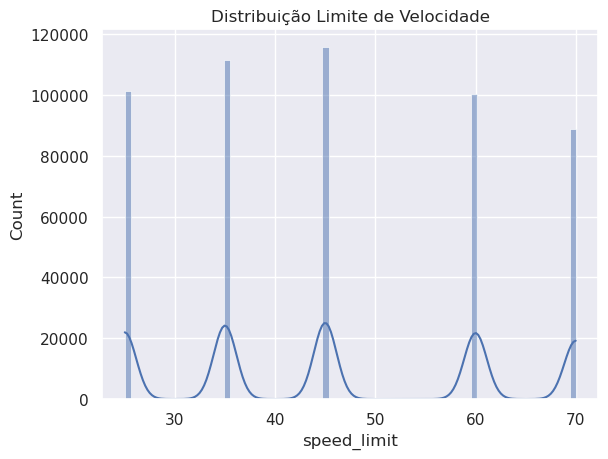

In [11]:
sns.histplot(treino['speed_limit'], kde=True)
plt.title('Distribuição Limite de Velocidade')

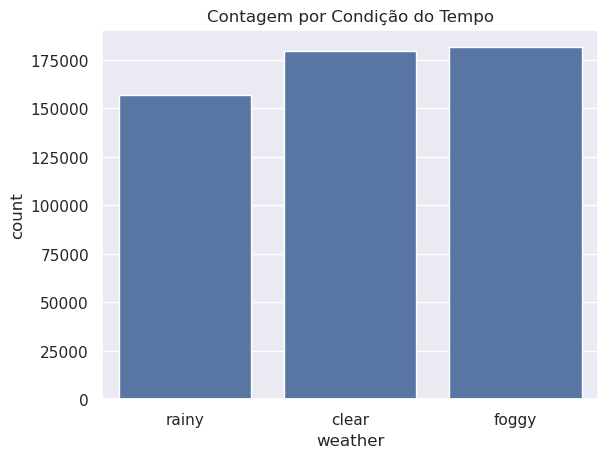

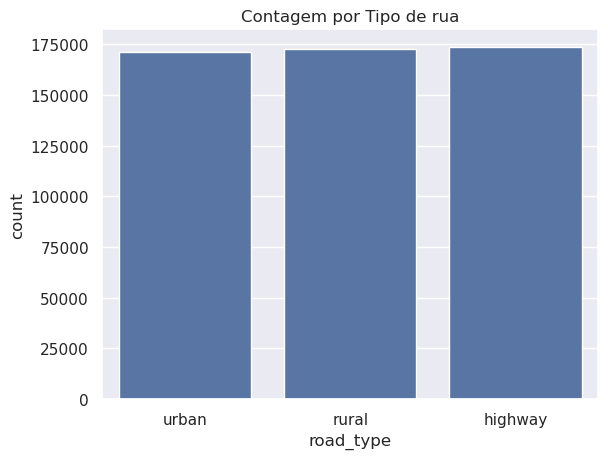

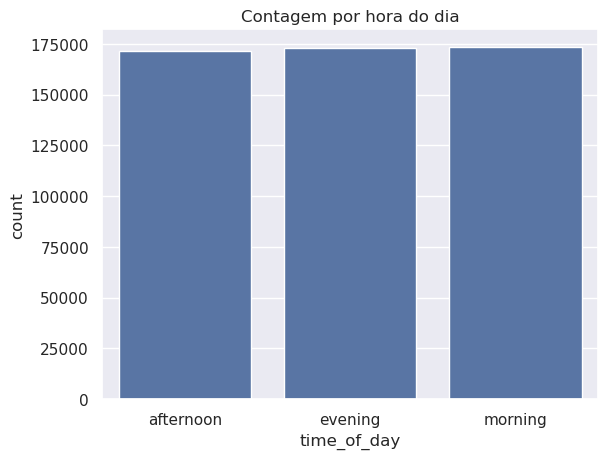

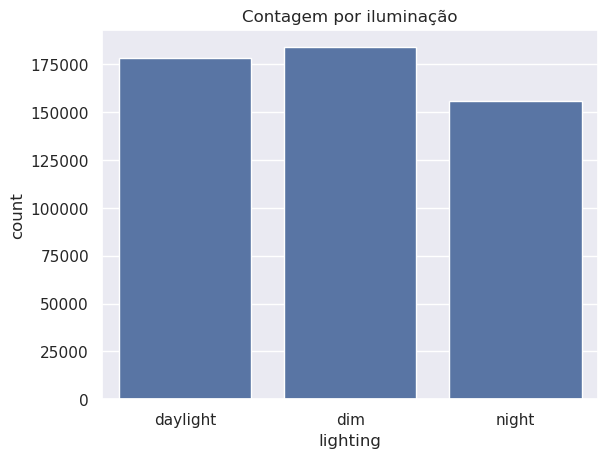

In [12]:
# Supondo uma coluna categórica 'weather_condition'
sns.countplot(x=('weather'), data=treino)
plt.title('Contagem por Condição do Tempo')
plt.show()

sns.countplot(x=('road_type'), data=treino)
plt.title('Contagem por Tipo de rua')
plt.show()

sns.countplot(x=('time_of_day'), data=treino)
plt.title('Contagem por hora do dia')
plt.show()

sns.countplot(x=('lighting'), data=treino)
plt.title('Contagem por iluminação')
plt.show()

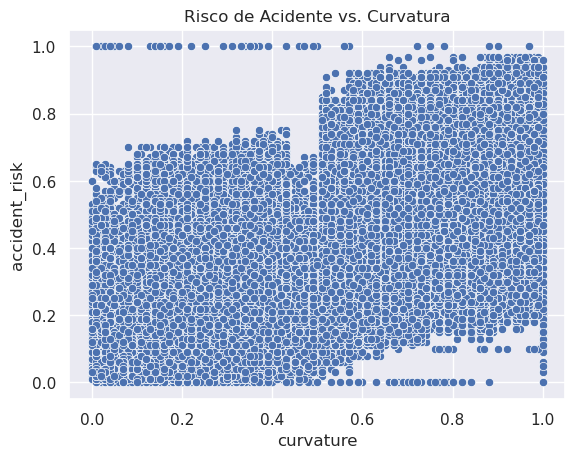

In [13]:
# Análise Bivariada com os mais correlacionados

sns.scatterplot(x='curvature', y='accident_risk',data=treino)
plt.title('Risco de Acidente vs. Curvatura')
plt.show()

In [14]:
# criar coluna para identificar maior curvaturas >= 0.5 pois há degrau na 
treino['curvatura_maior_que_05'] = (treino['curvature'] >= 0.5).astype('int')
print(treino[['curvature', 'curvatura_maior_que_05']].head())

   curvature  curvatura_maior_que_05
0       0.06                       0
1       0.99                       1
2       0.63                       1
3       0.07                       0
4       0.58                       1


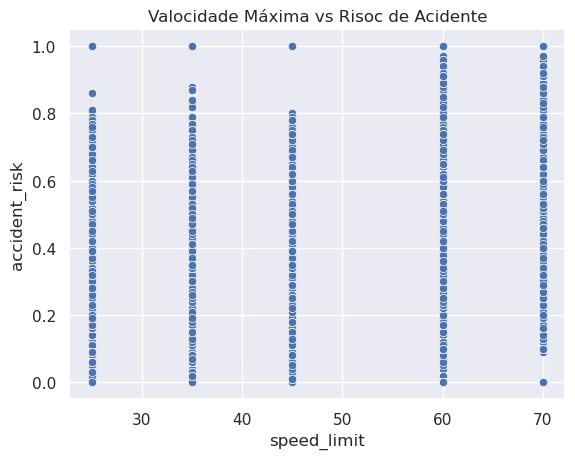

In [15]:
sns.scatterplot(data=treino, x='speed_limit', y='accident_risk')
plt.title('Valocidade Máxima vs Risoc de Acidente')
plt.show()

# Speed_limit é uma variável discreta/categóicca e não contínua como a curvatura
# Há uma clara relação pois quanto maior a velocidade, maior a concentração de risco de acidente
# Testar outra vizualização de gráfico, um gráfico para distribuição de categorias é melhor

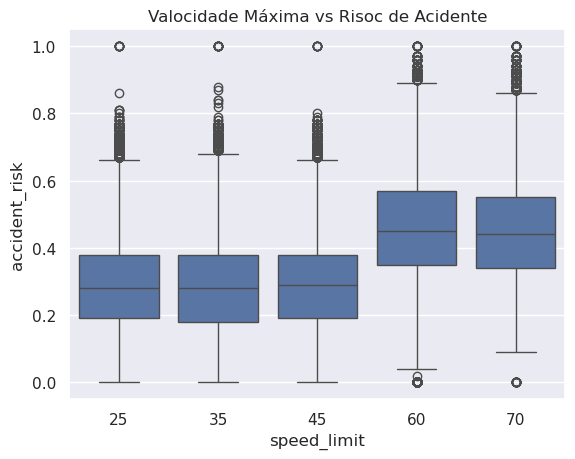

In [16]:
# gráfico com distribuição de categorias
sns.boxplot(data=treino, x='speed_limit', y='accident_risk')
plt.title('Valocidade Máxima vs Risoc de Acidente')
plt.show()

# Demonstra que há muitos outliers, grande salto de 45 para 60, os de valores menores sendo de 60 a 70. 60 há uma ccorrrelação maior com accident_risk do que de 70
# 25, 35 e 45 entram na mesma categoria 

In [17]:
# criar categoria abaixo dos 60 e acima dos 60 de limite de velocidade
treino['categoria_velocidade'] = np.where(treino['speed_limit']>=60, 'alta', 'baixa_media')
print(treino[['speed_limit','categoria_velocidade']].head())

   speed_limit categoria_velocidade
0           35          baixa_media
1           35          baixa_media
2           70                 alta
3           35          baixa_media
4           60                 alta


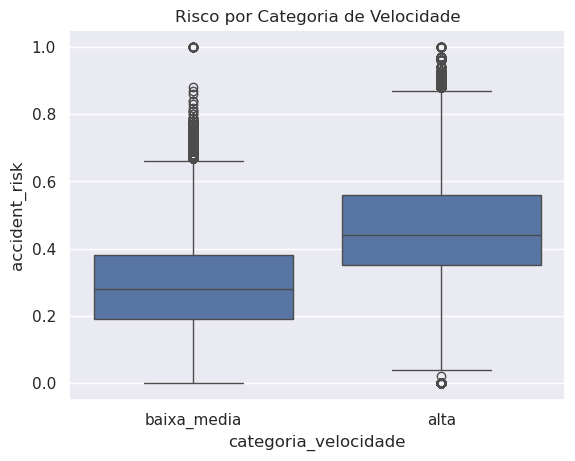

In [18]:
sns.boxplot(x='categoria_velocidade', y='accident_risk', data=treino)
plt.title('Risco por Categoria de Velocidade')
plt.show()

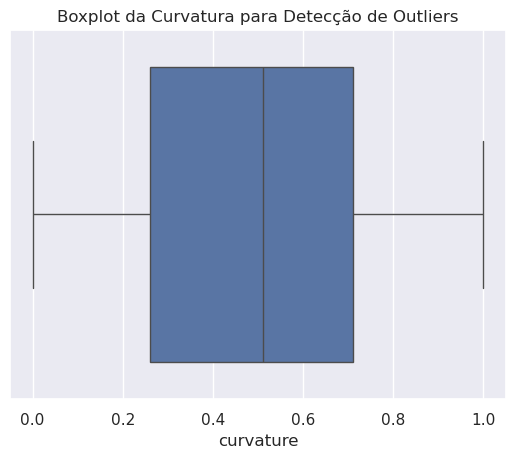

In [19]:
sns.boxplot(x=treino['curvature'])
plt.title('Boxplot da Curvatura para Detecção de Outliers')
plt.show()

In [20]:
treino['risco_alto_combinado'] = np.where((treino['categoria_velocidade'] == 'alta') & (treino['curvatura_maior_que_05'] == 1),1,0)
print(treino[['categoria_velocidade','curvatura_maior_que_05','risco_alto_combinado']].head())

  categoria_velocidade  curvatura_maior_que_05  risco_alto_combinado
0          baixa_media                       0                     0
1          baixa_media                       1                     0
2                 alta                       1                     1
3          baixa_media                       0                     0
4                 alta                       1                     1


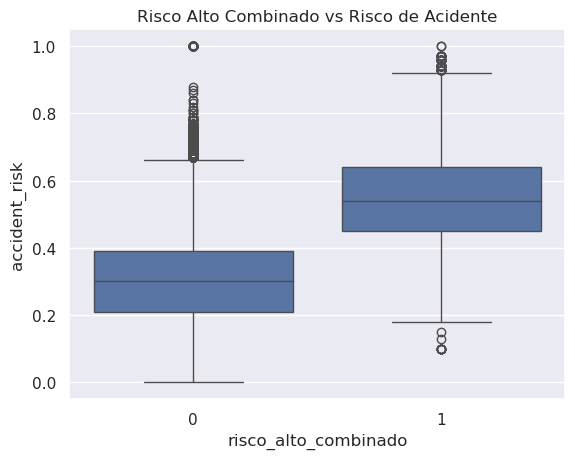

In [21]:
sns.boxplot(data = treino, x='risco_alto_combinado', y='accident_risk')
plt.title('Risco Alto Combinado vs Risco de Acidente')
plt.show()

#comparando com o boxplot do limite de velocidade o accident risk mínimo foi elevado e diminuiu a quantidade de outliers
# limiares (thresholds) mais importantes para essa análise foram curvature >= 0.5, speed_limit >= 60

### Verificação de colunas categóricas

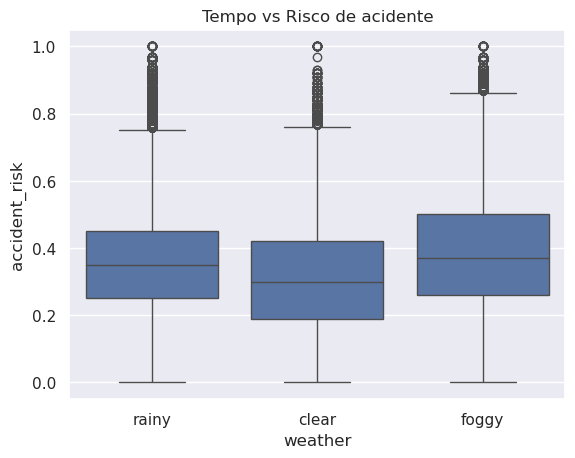

In [22]:
sns.boxplot(data=treino, x='weather', y ='accident_risk')
plt.title('Tempo vs Risco de acidente')
plt.show()

## Criar One-Hot Encoding (OHE), já que as variáveis tem pesos diferentes

In [23]:
treino = pd.get_dummies(treino, columns=['weather'])

In [24]:
treino.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,curvatura_maior_que_05,categoria_velocidade,risco_alto_combinado,weather_clear,weather_foggy,weather_rainy
0,0,urban,2,0.06,35,daylight,False,True,afternoon,False,True,1,0.13,0,baixa_media,0,False,False,True
1,1,urban,4,0.99,35,daylight,True,False,evening,True,True,0,0.35,1,baixa_media,0,True,False,False
2,2,rural,4,0.63,70,dim,False,True,morning,True,False,2,0.30,1,alta,1,True,False,False
3,3,highway,4,0.07,35,dim,True,True,morning,False,False,1,0.21,0,baixa_media,0,False,False,True
4,4,rural,1,0.58,60,daylight,False,False,evening,True,False,1,0.56,1,alta,1,False,True,False


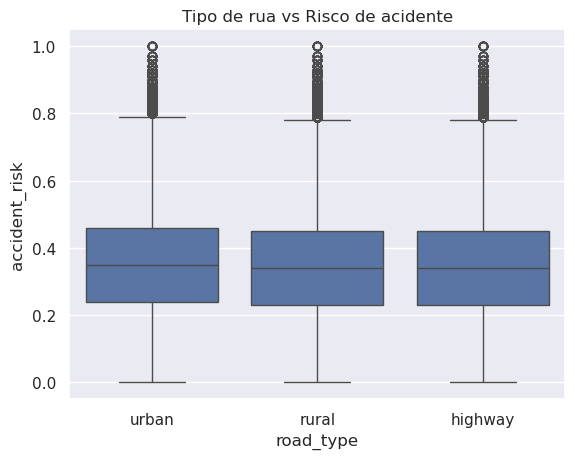

In [25]:
sns.boxplot(data=treino, x='road_type', y ='accident_risk')
plt.title('Tipo de rua vs Risco de acidente')
plt.show()

# retirar coluna já que não há impacto 

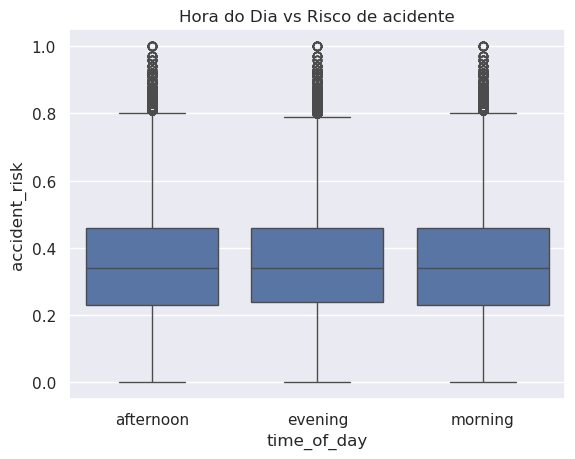

In [26]:
sns.boxplot(data=treino, x='time_of_day', y ='accident_risk')
plt.title('Hora do Dia vs Risco de acidente')
plt.show()

# retirar coluna já que não há impacto 

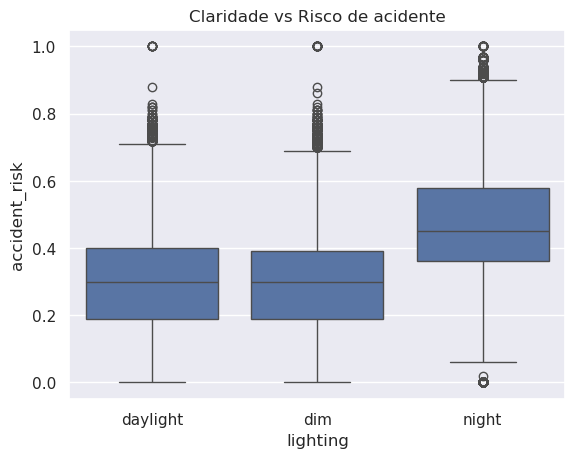

In [27]:
sns.boxplot(data=treino, x='lighting', y ='accident_risk')
plt.title('Claridade vs Risco de acidente')
plt.show()

## Ações para colunas categóricas

In [28]:
treino = treino.drop('road_type', axis=1)

In [29]:
treino = treino.drop('time_of_day', axis=1)

In [30]:
treino.head()

,id,num_lanes,curvature,speed_limit,lighting,road_signs_present,public_road,holiday,school_season,num_reported_accidents,accident_risk,curvatura_maior_que_05,categoria_velocidade,risco_alto_combinado,weather_clear,weather_foggy,weather_rainy
0,0,2,0.06,35,daylight,False,True,False,True,1,0.13,0,baixa_media,0,False,False,True
1,1,4,0.99,35,daylight,True,False,True,True,0,0.35,1,baixa_media,0,True,False,False
2,2,4,0.63,70,dim,False,True,True,False,2,0.30,1,alta,1,True,False,False
3,3,4,0.07,35,dim,True,True,False,False,1,0.21,0,baixa_media,0,False,False,True
4,4,1,0.58,60,daylight,False,False,True,False,1,0.56,1,alta,1,False,True,False


In [31]:
treino['eh_noite'] = (treino['lighting'] == 'night').astype(int)
treino[['eh_noite', 'lighting']].head(6)

,eh_noite,lighting
0,0,daylight
1,0,daylight
2,0,dim
3,0,dim
4,0,daylight
5,1,night


## Verificação de boolean

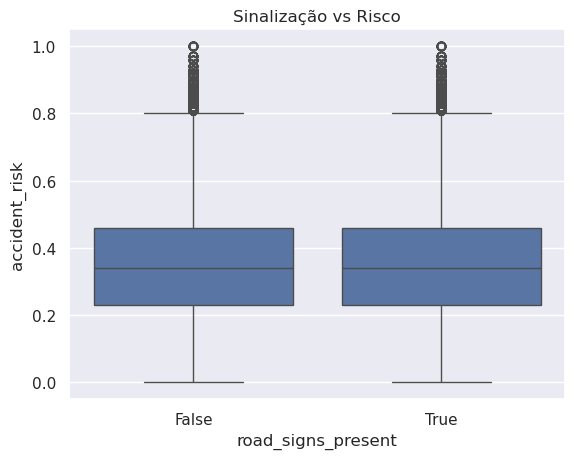

In [32]:
sns.boxplot(data=treino, x='road_signs_present', y='accident_risk')
plt.title('Sinalização vs Risco')
plt.show()

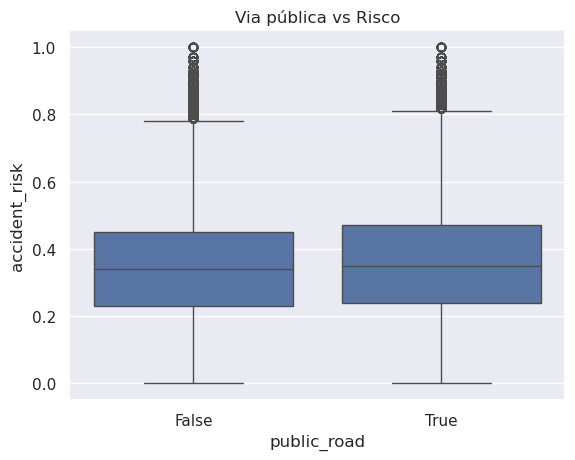

In [33]:
sns.boxplot(data=treino, x='public_road', y='accident_risk')
plt.title('Via pública vs Risco')
plt.show()

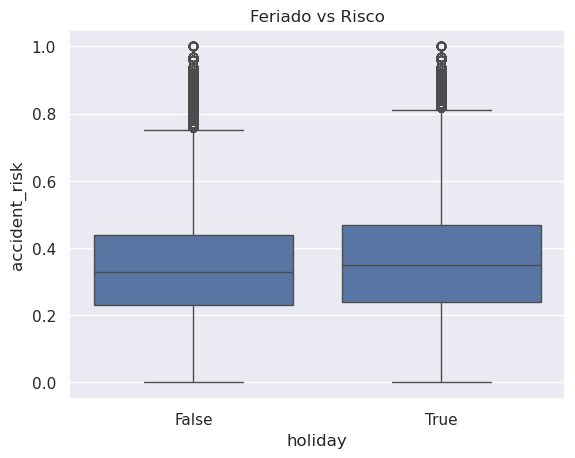

In [34]:
sns.boxplot(data=treino, x='holiday', y='accident_risk')
plt.title('Feriado vs Risco')
plt.show()

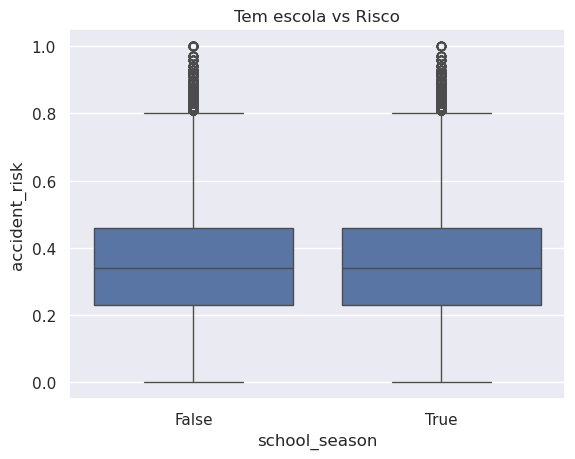

In [35]:
sns.boxplot(data=treino, x='school_season', y='accident_risk')
plt.title('Tem escola vs Risco')
plt.show()

In [36]:
# Nenhuma coluna gera resultado que possa ser utilizado para o treinamento do modelo
colunas = [
    'school_season',
    'public_road',
    'holiday',
    'road_signs_present'
]
treino = treino.drop(columns=colunas)

In [37]:
print(treino.columns)

Index(['id', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'num_reported_accidents', 'accident_risk', 'curvatura_maior_que_05',
       'categoria_velocidade', 'risco_alto_combinado', 'weather_clear',
       'weather_foggy', 'weather_rainy', 'eh_noite'],
      dtype='object')


# Verificação de variáveis esquecidas (road_lanes, accident reports)

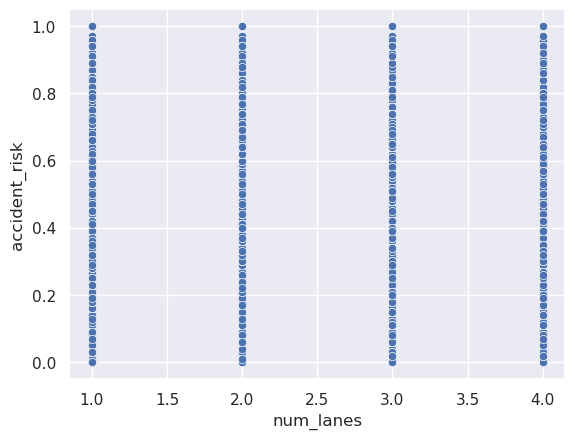

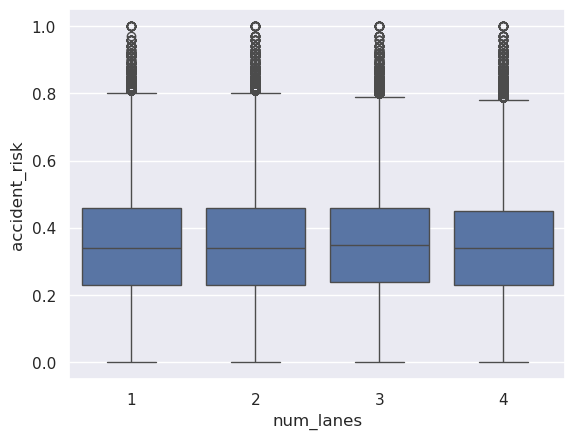

In [38]:
sns.scatterplot(data=treino, x='num_lanes', y='accident_risk')
plt.show()

# variável categórica, fazer boxplot
sns.boxplot(data=treino, x='num_lanes', y='accident_risk')
plt.show()

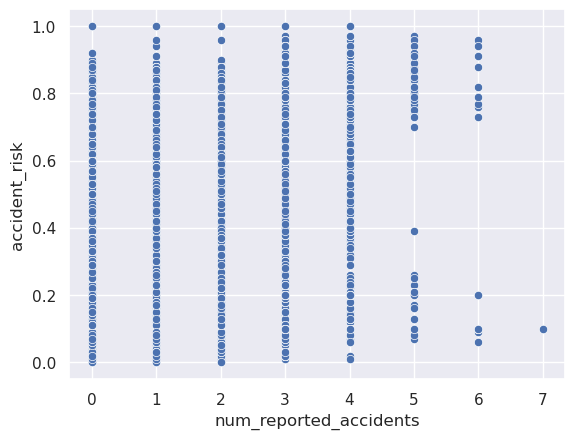

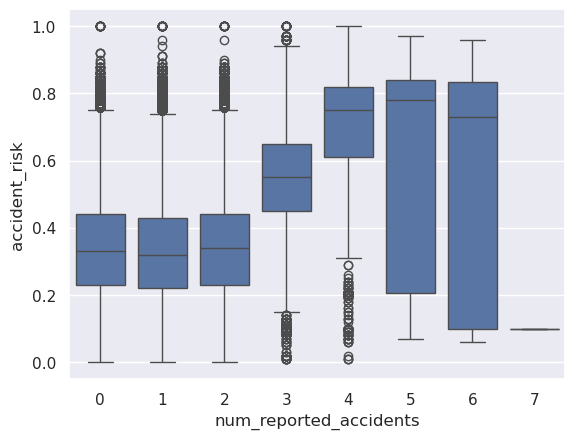

<Axes: xlabel='num_reported_accidents', ylabel='count'>

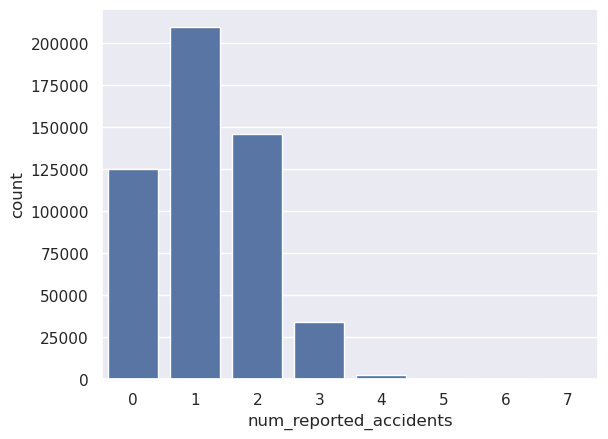

In [39]:
sns.scatterplot(data=treino, x='num_reported_accidents', y='accident_risk')
plt.show()

sns.boxplot(data=treino, x='num_reported_accidents', y='accident_risk')
plt.show()
# gerou dúvida, portanto vou ver como está a distribuição

sns.countplot(data=treino, x='num_reported_accidents')

# fazer binning para que consiga separar os casos com risco mais alto e também com mais ou menos frequência

## Realização de ações para os dois últimos casos

In [40]:
def acidentes_reportados(num):
    if num <= 2:
        return('Baixo (0-2)')
    elif num == 3:
        return('Médio (3)')
    else:
        return('Alto (4+)')

treino['acidentes_reportados'] = treino['num_reported_accidents'].apply(acidentes_reportados)

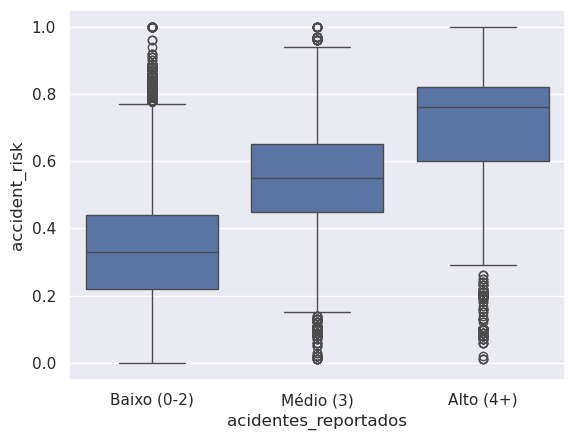

In [41]:
sns.boxplot(data=treino, x='acidentes_reportados', y='accident_risk')
plt.show()

## Remover colunas que receberam features

In [42]:
treino.columns

Index(['id', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'num_reported_accidents', 'accident_risk', 'curvatura_maior_que_05',
       'categoria_velocidade', 'risco_alto_combinado', 'weather_clear',
       'weather_foggy', 'weather_rainy', 'eh_noite', 'acidentes_reportados'],
      dtype='object')

In [44]:
colunas = ['num_lanes','curvature', 'speed_limit', 'lighting', 'num_reported_accidents', 'id']
modelo_final = treino.drop(columns=colunas)

In [45]:
treino.head()

,id,num_lanes,curvature,speed_limit,lighting,num_reported_accidents,accident_risk,curvatura_maior_que_05,categoria_velocidade,risco_alto_combinado,weather_clear,weather_foggy,weather_rainy,eh_noite,acidentes_reportados
0,0,2,0.06,35,daylight,1,0.13,0,baixa_media,0,False,False,True,0,Baixo (0-2)
1,1,4,0.99,35,daylight,0,0.35,1,baixa_media,0,True,False,False,0,Baixo (0-2)
2,2,4,0.63,70,dim,2,0.30,1,alta,1,True,False,False,0,Baixo (0-2)
3,3,4,0.07,35,dim,1,0.21,0,baixa_media,0,False,False,True,0,Baixo (0-2)
4,4,1,0.58,60,daylight,1,0.56,1,alta,1,False,True,False,0,Baixo (0-2)


In [46]:
modelo_final.head()

,accident_risk,curvatura_maior_que_05,categoria_velocidade,risco_alto_combinado,weather_clear,weather_foggy,weather_rainy,eh_noite,acidentes_reportados
0,0.13,0,baixa_media,0,False,False,True,0,Baixo (0-2)
1,0.35,1,baixa_media,0,True,False,False,0,Baixo (0-2)
2,0.30,1,alta,1,True,False,False,0,Baixo (0-2)
3,0.21,0,baixa_media,0,False,False,True,0,Baixo (0-2)
4,0.56,1,alta,1,False,True,False,0,Baixo (0-2)
